# Simple CEM on Continuous Bandits

In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt
import bisect
import math
import matplotlib.cm as cm

## Main Idea
This code is aimed to observe whether the CEM method proposed in the slides will strictly improve in a "$1 - \rho$ quantile" sense. To check this, we created a continuous bandit depicted in Figure 1 (在下面~).

### Figure 1. (code of plotting it, and the resulting figure is plotted below)

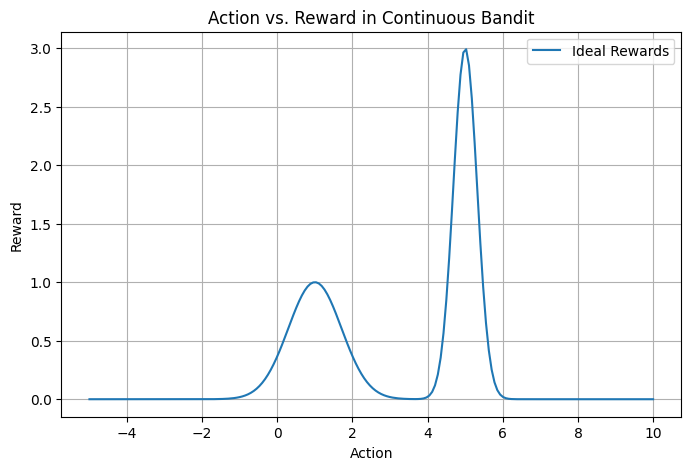

In [3]:
reward_disturb = np.random.default_rng()
reward_disturb_std = 0.0
def c_bandit(action, reward_disturb_std=0):
    reward = reward_disturb.normal(np.exp(-(action - 1)**2) + 3 * np.exp(-(action - 5)**2 * 5), reward_disturb_std)
    # reward = reward_disturb.normal(np.sin(action) - 0.03 * np.abs(action - 6), reward_disturb_std)
    return reward

# Generate actions in the range [-1, 1]
actions = np.linspace(-5, 10, 200)
rewards = [c_bandit(a, reward_disturb_std) for a in actions]

# Plotting
plt.figure(figsize=(8, 5))
# plt.scatter(actions, rewards, alpha=0.6, label="Sampled Rewards")
plt.plot(actions, [c_bandit(a) for a in actions], label="Ideal Rewards")
plt.title("Action vs. Reward in Continuous Bandit")
plt.xlabel("Action")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()

In [4]:
metrics = {
    "pi(the current mean action)": [],
    "pi(the updated mean action)": [],
    "true policy gradient w.r.t. mu": [],
    "true policy gradient w.r.t. sigma": []
}

def normal_pdf(x: float, mu: float = 0.0, sigma: float = 1.0) -> float:
    """
    Return φ((x-μ)/σ): the PDF of N(μ, σ²) at x.
    """
    if sigma <= 0:
        raise ValueError("sigma must be positive")
    z = (x - mu) / sigma
    return (1.0 / (sigma * np.sqrt(2.0 * np.pi))) * np.exp(-0.5 * z * z)

def pdf_gradients(x: float, mu: float = 0.0, sigma: float = 1.0):
    """
    Return (∂pdf/∂mu, ∂pdf/∂sigma) for the normal distribution N(mu, sigma^2).
    """
    if sigma <= 0:
        raise ValueError("sigma must be positive")

    pdf_val = normal_pdf(x, mu, sigma)
    dmu = pdf_val * (x - mu) / (sigma**2)
    dsigma = pdf_val * ((x - mu)**2 / (sigma**3) - 1.0/sigma)
    return dmu, dsigma

def calculate_true_PG(mu, sigma):
    action_list = np.arange(-10, 10, 0.01)
    gradient_mu = 0
    gradient_sigma = 0
    for a in action_list:
        dmu, dsigma = pdf_gradients(a, mu, sigma)
        gradient_mu += c_bandit(a) * dmu * 0.01
        gradient_sigma += c_bandit(a) * dsigma * 0.01

    return gradient_mu, gradient_sigma

### Figure 2. Result
If the iteration failed to improve, it will output "Uh-oh😢", then stop the algorithm. (Also, it may take some time to run, because I tried to sample a huge number, or INFINITE, actions).

gamma on iteration 0: 0.9995680815208735


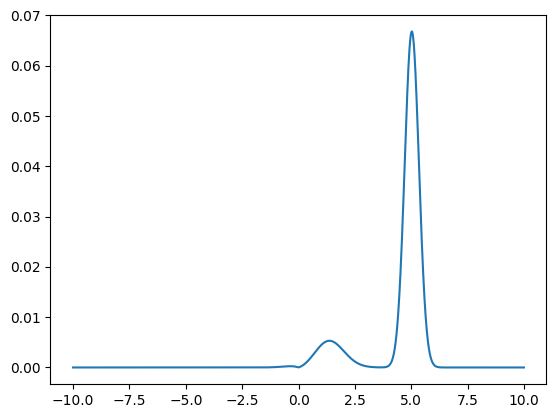

mu on iteration 0: 0.0 

gamma on iteration 1: 0.9999378854025017
its corresponding max_rho: 0.01787344643038291
mu on iteration 1: 1.4359060824700107 

gamma on iteration 2: 2.9747271050184754
its corresponding max_rho: 0.11528967947663105
mu on iteration 2: 2.99906782931188 

gamma on iteration 3: 2.9999987696293706
its corresponding max_rho: 0.9169159907684434
mu on iteration 3: 4.999753933833876 



In [ ]:
# ---------------------------
# your loop, with history tracking of (mu, sigma)
# ---------------------------
p = 0.01  # Pick up the top p-quantile
final_means = []
max_rhos = []

mu_sigma_history = []  # <--- store (mu, sigma) at each update

for i in range(1):  # How many experiments to run
    mu = 0.0
    sigma = 1.5
    actions_generator = np.random.default_rng()
    previous_gamma = -99999
    t = 0
    while sigma >= 0.001:
        # keep the current distribution (before the update) for plotting
        mu_sigma_history.append((mu, sigma))

        sampled_actions = actions_generator.normal(mu, sigma, 9_000_000)  # sample INFINITE actions
        obtained_rewards = c_bandit(sampled_actions)
        sorted_obtained_rewards = np.sort(obtained_rewards)
        gamma = np.quantile(sorted_obtained_rewards, 1 - p)  # threshold

        print(f"gamma on iteration {t}:", gamma)
        if t > 0:
            # NOTE: len(sampled_actions) - 1 matches your earlier denominator
            max_rho = 1 - (np.searchsorted(sorted_obtained_rewards, previous_gamma, side="right") / (len(sampled_actions) - 1))
            max_rhos.append(max_rho)
            if previous_gamma > gamma:
                print("Uh-oh😢")
                # break
            print(f"its corresponding max_rho:", max_rho)
        print(f"mu on iteration {t}:", mu, "\n")

        elite_actions = sampled_actions[obtained_rewards >= gamma]

        # (optional) your metrics logging can stay as-is if you have these funcs/vars defined elsewhere
        # metrics["pi(the current mean action)"].append(normal_pdf(mu, mu, sigma))
        mu_new = np.mean(elite_actions)
        # metrics["pi(the updated mean action)"].append(normal_pdf(mu_new, mu, sigma))
        # gradient_mu, gradient_sigma = calculate_true_PG(mu, sigma)
        # metrics["true policy gradient w.r.t. mu"].append(gradient_mu)
        # metrics["true policy gradient w.r.t. sigma"].append(gradient_sigma)

        # Update
        mu = mu_new
        sigma = np.std(elite_actions, ddof=0)
        previous_gamma = gamma
        t += 1

    final_means.append(mu)

/tmp/ipykernel_56604/3115629087.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("autumn", n_steps)  # use the "cool" colormap


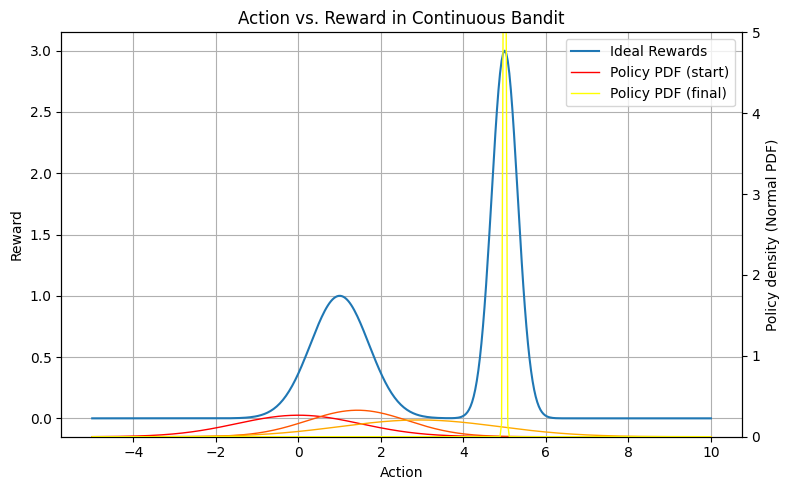

In [15]:
# ---------------------------
# Plot rewards and the whole policy trajectory of PDFs
# ---------------------------
actions = np.linspace(-5, 10, 400)
rewards = [c_bandit(a, reward_disturb_std) for a in actions]

fig, ax1 = plt.subplots(figsize=(8, 5))

# reward side
# ax1.scatter(actions, rewards, alpha=0.6, label="Sampled Rewards")
ax1.plot(actions, [c_bandit(a) for a in actions], label="Ideal Rewards")
ax1.set_title("Action vs. Reward in Continuous Bandit")
ax1.set_xlabel("Action")
ax1.set_ylabel("Reward")
ax1.grid(True)

# policy PDFs on a twin y-axis (density scale)
ax2 = ax1.twinx()
ax2.set_ylabel("Policy density (Normal PDF)")

# alpha increases from light (old) to dark (recent)
n_steps = len(mu_sigma_history)
if n_steps > 0:
    # alphas = np.linspace(0.9, 0.3, n_steps)
    cmap = cm.get_cmap("autumn", n_steps)  # use the "cool" colormap
    for i, (m, s) in enumerate(mu_sigma_history):
        lw = 1.0 #if i < n_steps - 1 else 2.4   # last (most recent) thicker
        lbl = None
        if i == 0:
            lbl = "Policy PDF (start)"
        elif i == n_steps - 1:
            lbl = "Policy PDF (final)"
        ax2.plot(actions, normal_pdf(actions, m, s), linewidth=lw, label=lbl, color=cmap(i))
        ax2.set_ylim(0, 5)

# combine legends nicely
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Maximum Requirements of rho to Improve the Reward Quantile')

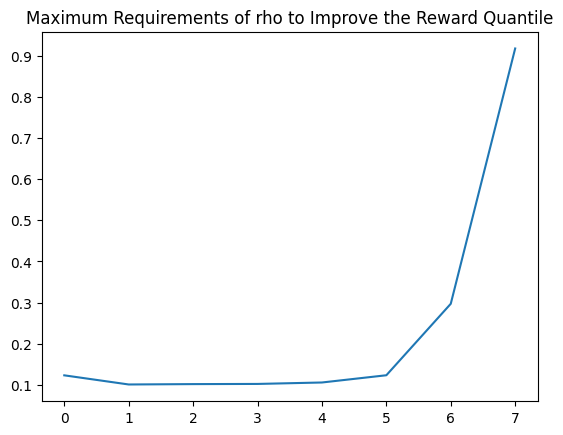

In [ ]:
import matplotlib.pyplot as plt
plt.plot(max_rhos)
plt.title("Maximum Requirements of rho to Improve the Reward Quantile")

In [ ]:
# Calculate difference of metrics
def calculate_difference(metric):
    d_metric = [metric[t + 1] - metric[t] for t in range(len(metric) - 1)]
    return d_metric

In [ ]:
(metrics["pi(the updated mean action)"])

[0.39854907582036997,
 np.float64(0.6766209640420201),
 np.float64(0.6868322446749232),
 np.float64(0.707171342819519),
 np.float64(0.7422029501483148),
 np.float64(0.8111406098635541),
 np.float64(1.015642368669047),
 np.float64(3.0738936161033212),
 np.float64(42.349278483358475)]

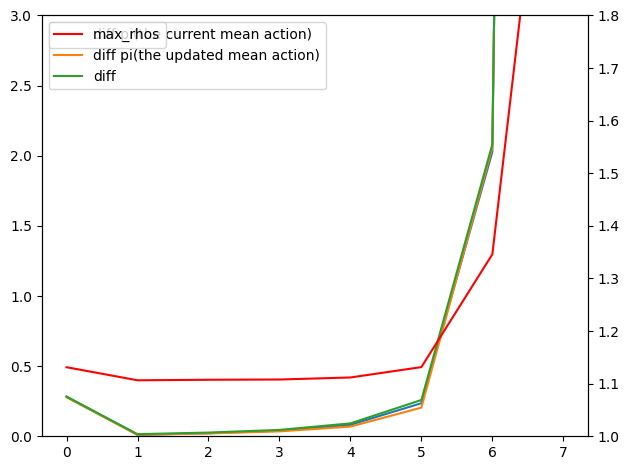

In [ ]:
diff_pi_cma = np.array(calculate_difference(metrics["pi(the current mean action)"]))
diff_pi_uma = np.array(calculate_difference(metrics["pi(the updated mean action)"]))
diff = np.array(
    [metrics["pi(the current mean action)"][t] - metrics["pi(the updated mean action)"][t - 1] for t in range(1, len(metrics["pi(the current mean action)"]))]
)
fig, ax1 = plt.subplots()
ax1.plot(diff_pi_cma, label="diff pi(the current mean action)")
ax1.plot(diff_pi_uma, label="diff pi(the updated mean action)")
ax1.plot(diff, label="diff")
ax1.legend()
ax1.set_ylim((0, 3))

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.plot(np.exp(np.array(max_rhos)), label="max_rhos", color="red")
ax2.legend()
ax2.set_ylim((1, 1.8))
fig.tight_layout()
plt.show()

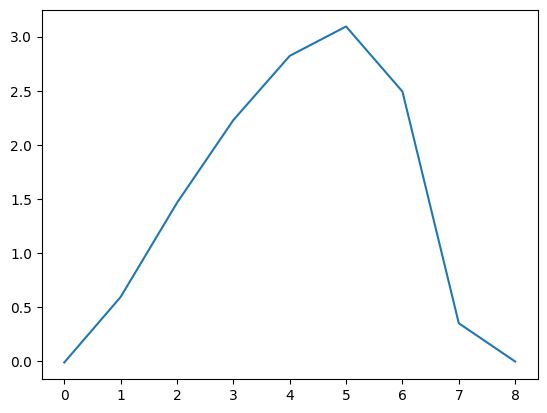

In [ ]:
plt.plot(metrics["true policy gradient w.r.t. mu"])

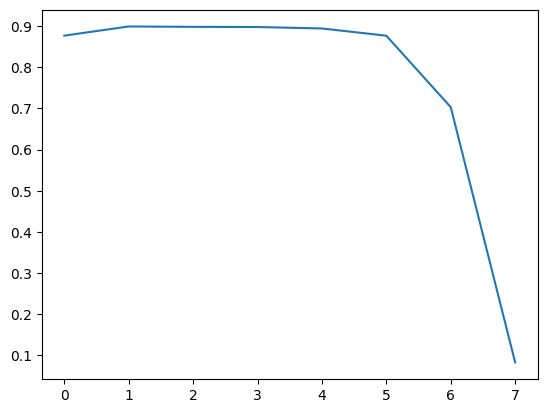

In [ ]:
plt.plot([1 - rho for rho in max_rhos])

In [ ]:
max_rhos

[0.12336334704037188,
 0.10115523346169264,
 0.10205301133922351,
 0.10248145583127288,
 0.10597356733039642,
 0.12355801372866815,
 0.2971449219049913,
 0.9172402130266903]